###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [3]:
import math

In [4]:
np.random.seed(1337)
random.seed(1337)

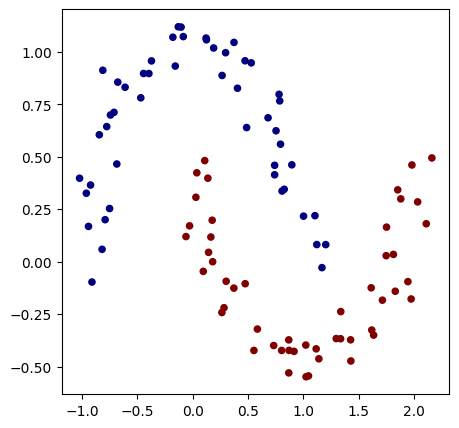

In [5]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [6]:
# initialize a model 
np.random.seed(1337)
random.seed(1337)
model = MLP(2, [3,3,3,3,1]) # 1-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer 'l0' of [TanhNeuron(2), TanhNeuron(2), TanhNeuron(2)], Layer 'l1' of [TanhNeuron(3), TanhNeuron(3), TanhNeuron(3)], Layer 'l2' of [TanhNeuron(3), TanhNeuron(3), TanhNeuron(3)], Layer 'l3' of [TanhNeuron(3), TanhNeuron(3), TanhNeuron(3)], Layer 'l4' of [LinearNeuron(3)]]
number of parameters 62


In [7]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, map(float,xrow))) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)
model.zero_grad()

+:(data=0.99439, grad=0.00000) 0.78


In [8]:
# visualize decision boundary
def visualizeBoundary():
    h = 0.05
    x_min, x_max = X[:, 0].min() - 2, X[:, 0].max() + 2
    y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())   

In [10]:
# optimization
from cmath import sqrt

def sgn(value:float):
    if value >= 0:
        return 1.   
    return -1.

model.init_learning_rate()

size = 5000
last_max_grad_value = None
for k in range(size):
    
    # forward
    total_loss, acc = loss()

    if acc >= 1.0:
        print("Accuracy reached.")
        break
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    #learning_rate = 1.0 - 0.8*k/size
    #learning_rate = 0.001
    #learning_rate = 5.*total_loss.data
    max_grad = 0
    max_grad_no_abs = 0
    max_grad_value = None

    parameters = model.parameters()
    for p in parameters:
        abs_grad = abs(p.grad)
        if abs_grad > max_grad:
            max_grad = abs_grad
            max_grad_no_abs = p.grad
            max_grad_value = p

    """if sgn(max_grad_value.grad) != sgn(max_grad_value.last_grad):
        learning_rate *= 0.99
    else:
        learning_rate /= 0.99"""
    
    last_max_grad_value = max_grad_value

    count_sgn_switches = 0

    learning_rate = 0.0
    
    for p in parameters:
        switched = 1 if sgn(p.grad) != sgn(p.last_grad) else 0
        count_sgn_switches += switched
        if switched == 1:
            p.learning_rate = max(min(0.75,p.learning_rate * 0.5),0.01)
        else:
            #step_to_do = (0 - p.grad)
            #step_done = (p.grad - p.last_grad)
            p.learning_rate = min(p.learning_rate * 1.1,1.0)
            #p.learning_rate = min(p.learning_rate * abs(step_to_do / step_done),10)


        #p.learning_rate = min(p.learning_rate * abs(step_to_do / step_done),10)
        learning_rate += p.learning_rate / len(parameters)



        update_value = p.learning_rate * p.grad



        p.last_grad = p.grad
        p.data -= update_value

    if max_grad < 0.0001:
        print("Plateau reached.")
        break
   
    if k % 1 == 0:
        print(f"step {k} learning rate: {learning_rate:.5f} loss: {total_loss.data:.5f}, accuracy: {acc*100}%, max_grad: {max_grad_no_abs:.5f}, max_grad_neuron: {max_grad_value._op}, max_grad_data: {max_grad_value.data}, sgn switches: {count_sgn_switches}")

print(model.parameters())

step 0 learning rate: 0.62097 loss: 0.22817, accuracy: 90.0%, max_grad: -0.47110, max_grad_neuron: l0n2b, max_grad_data: -0.08677041456027457, sgn switches: 47
step 1 learning rate: 0.42984 loss: 0.33752, accuracy: 83.0%, max_grad: 0.60271, max_grad_neuron: l0n2w0, max_grad_data: -0.39969725014072655, sgn switches: 46
step 2 learning rate: 0.45185 loss: 0.28708, accuracy: 87.0%, max_grad: 1.18221, max_grad_neuron: l0n2w0, max_grad_data: -0.724805278833281, sgn switches: 0
step 3 learning rate: 0.41220 loss: 0.29350, accuracy: 85.0%, max_grad: -0.45428, max_grad_neuron: l0n2b, max_grad_data: -0.2988800000587716, sgn switches: 24
step 4 learning rate: 0.36150 loss: 0.27947, accuracy: 86.0%, max_grad: 0.13010, max_grad_neuron: l0n2b, max_grad_data: -0.3078241727022077, sgn switches: 31
step 5 learning rate: 0.34637 loss: 0.27585, accuracy: 87.0%, max_grad: -0.10702, max_grad_neuron: l0n2w0, max_grad_data: -0.7185460528815347, sgn switches: 11
step 6 learning rate: 0.32011 loss: 0.27349, a

KeyboardInterrupt: 

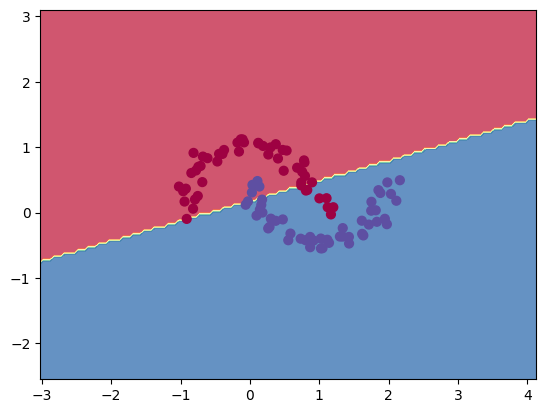

In [11]:
visualizeBoundary()